# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

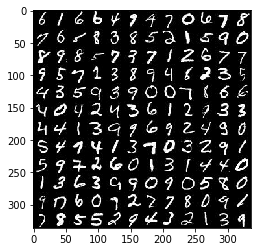

In [2]:
show_n_images = 150

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

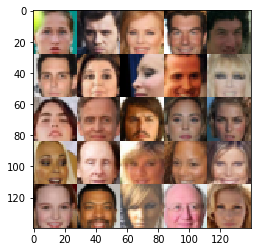

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [66]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, shape=None, name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [86]:
def leaky_relu(alpha, x):
    return tf.maximum(alpha * x, x)

def make_conv_layer(x, filters, alpha, kernel=5, strides=2, padding="same", use_batch_norm=True):
        layer = tf.layers.conv2d(
            x, 
            filters,
            kernel, 
            strides=strides,
            padding=padding,
            kernel_initializer=tf.random_normal_initializer(stddev=0.02)
        )
        if use_batch_norm:
            layer = tf.layers.batch_normalization(layer, training=True)
        layer = leaky_relu(alpha, layer)
        
        return layer


def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boo|lean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        layer1 = make_conv_layer(images, 64, alpha, use_batch_norm=False)
        layer2 = make_conv_layer(layer1, 128, alpha)
        layer3 = make_conv_layer(layer2, 256, alpha, strides=1)

        flat = tf.reshape(layer3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [109]:
def make_conv_transpose_layer(x, filters, kernel=5, strides=2, padding="same", alpha=0.2, training=True):
        layer = tf.layers.conv2d_transpose(
            x,
            filters,
            kernel,
            strides=strides,
            padding=padding,
            kernel_initializer=tf.random_normal_initializer(stddev=0.02)
        )
        layer = tf.layers.batch_normalization(layer, training=training)
        layer = leaky_relu(alpha, layer)
        
        return layer

def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        layer1 = tf.layers.dense(z, 7*7*256)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(alpha, layer1)
        
        layer2 = make_conv_transpose_layer(layer1, 128, training=is_train, alpha=alpha)
        
        layer3 = make_conv_transpose_layer(layer2, 64, training=is_train, alpha=alpha)
        logits =  tf.layers.conv2d_transpose(layer3, out_channel_dim, 3, strides=1, padding="same")
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [110]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [111]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [112]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [119]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    print("Image width {}, image height {} image channels {}".format(image_width, image_height, image_channels))
    print("z_dim {}".format(z_dim))
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    out_channel_dim = len(data_image_mode)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                batch_images= batch_images*2 # rescale images to be from -1, 1 instead of -0.5 to 0.5
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if i % 50 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                i+=1
            show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Image width 28, image height 28 image channels 1
z_dim 100
Epoch 1/2... Batch 0... Discriminator Loss: 4.8749... Generator Loss: 0.0137


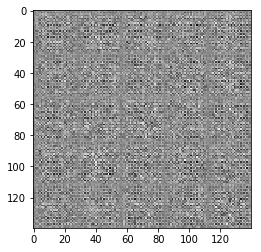

Epoch 1/2... Batch 10... Discriminator Loss: 3.1511... Generator Loss: 0.0724
Epoch 1/2... Batch 20... Discriminator Loss: 3.3120... Generator Loss: 0.0756
Epoch 1/2... Batch 30... Discriminator Loss: 2.5560... Generator Loss: 0.1555
Epoch 1/2... Batch 40... Discriminator Loss: 2.0948... Generator Loss: 0.3133
Epoch 1/2... Batch 50... Discriminator Loss: 1.9159... Generator Loss: 0.3163


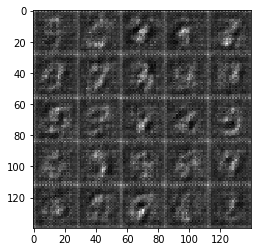

Epoch 1/2... Batch 60... Discriminator Loss: 1.8434... Generator Loss: 0.3719
Epoch 1/2... Batch 70... Discriminator Loss: 1.9091... Generator Loss: 0.2812
Epoch 1/2... Batch 80... Discriminator Loss: 1.6393... Generator Loss: 1.0822
Epoch 1/2... Batch 90... Discriminator Loss: 1.6876... Generator Loss: 1.1276
Epoch 1/2... Batch 100... Discriminator Loss: 1.3527... Generator Loss: 1.1687


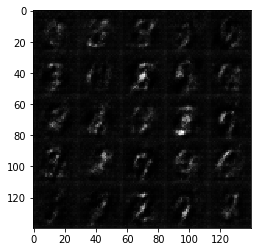

Epoch 1/2... Batch 110... Discriminator Loss: 1.3876... Generator Loss: 0.6400
Epoch 1/2... Batch 120... Discriminator Loss: 1.6743... Generator Loss: 0.3750
Epoch 1/2... Batch 130... Discriminator Loss: 1.4957... Generator Loss: 0.6236
Epoch 1/2... Batch 140... Discriminator Loss: 1.4410... Generator Loss: 0.5784
Epoch 1/2... Batch 150... Discriminator Loss: 1.5594... Generator Loss: 0.4069


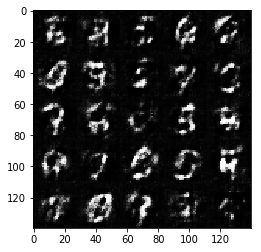

Epoch 1/2... Batch 160... Discriminator Loss: 1.3018... Generator Loss: 0.6068
Epoch 1/2... Batch 170... Discriminator Loss: 1.2446... Generator Loss: 1.2414
Epoch 1/2... Batch 180... Discriminator Loss: 1.3151... Generator Loss: 0.7082
Epoch 1/2... Batch 190... Discriminator Loss: 1.4747... Generator Loss: 0.4830
Epoch 1/2... Batch 200... Discriminator Loss: 1.2584... Generator Loss: 0.7809


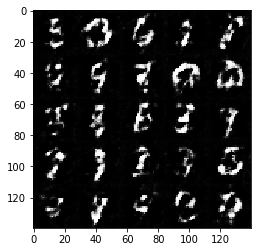

Epoch 1/2... Batch 210... Discriminator Loss: 1.2328... Generator Loss: 0.7514
Epoch 1/2... Batch 220... Discriminator Loss: 1.2181... Generator Loss: 0.7363
Epoch 1/2... Batch 230... Discriminator Loss: 1.3218... Generator Loss: 0.5502
Epoch 1/2... Batch 240... Discriminator Loss: 1.2599... Generator Loss: 0.9303
Epoch 1/2... Batch 250... Discriminator Loss: 1.2559... Generator Loss: 0.7292


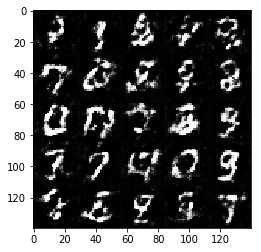

Epoch 1/2... Batch 260... Discriminator Loss: 1.2029... Generator Loss: 0.8268
Epoch 1/2... Batch 270... Discriminator Loss: 1.8409... Generator Loss: 0.2936
Epoch 1/2... Batch 280... Discriminator Loss: 1.9802... Generator Loss: 0.2536
Epoch 1/2... Batch 290... Discriminator Loss: 1.4564... Generator Loss: 0.9556
Epoch 1/2... Batch 300... Discriminator Loss: 1.3941... Generator Loss: 0.6728


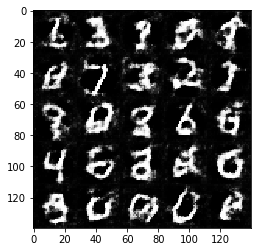

Epoch 1/2... Batch 310... Discriminator Loss: 1.4209... Generator Loss: 0.5727
Epoch 1/2... Batch 320... Discriminator Loss: 1.6073... Generator Loss: 0.4159
Epoch 1/2... Batch 330... Discriminator Loss: 1.7073... Generator Loss: 1.3472
Epoch 1/2... Batch 340... Discriminator Loss: 1.2600... Generator Loss: 0.7620
Epoch 1/2... Batch 350... Discriminator Loss: 1.4843... Generator Loss: 0.4748


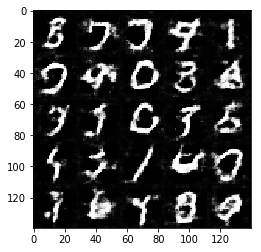

Epoch 1/2... Batch 360... Discriminator Loss: 1.2981... Generator Loss: 1.1662
Epoch 1/2... Batch 370... Discriminator Loss: 1.7271... Generator Loss: 0.3595
Epoch 1/2... Batch 380... Discriminator Loss: 1.3510... Generator Loss: 0.7124
Epoch 1/2... Batch 390... Discriminator Loss: 1.4409... Generator Loss: 0.5361
Epoch 1/2... Batch 400... Discriminator Loss: 1.3744... Generator Loss: 0.9528


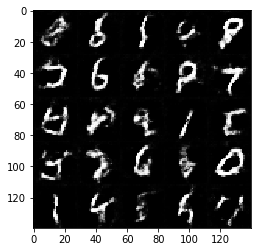

Epoch 1/2... Batch 410... Discriminator Loss: 1.3889... Generator Loss: 0.7710
Epoch 1/2... Batch 420... Discriminator Loss: 1.2482... Generator Loss: 0.8800
Epoch 1/2... Batch 430... Discriminator Loss: 1.4248... Generator Loss: 0.6281
Epoch 1/2... Batch 440... Discriminator Loss: 1.2253... Generator Loss: 0.8256
Epoch 1/2... Batch 450... Discriminator Loss: 1.2848... Generator Loss: 0.7287


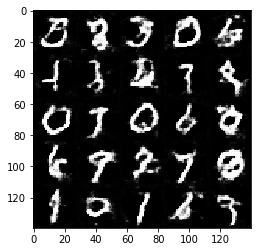

Epoch 1/2... Batch 460... Discriminator Loss: 1.3516... Generator Loss: 0.6830
Epoch 1/2... Batch 470... Discriminator Loss: 1.3893... Generator Loss: 0.5619
Epoch 1/2... Batch 480... Discriminator Loss: 1.4103... Generator Loss: 0.6149
Epoch 1/2... Batch 490... Discriminator Loss: 1.3705... Generator Loss: 0.6388
Epoch 1/2... Batch 500... Discriminator Loss: 1.3923... Generator Loss: 0.7981


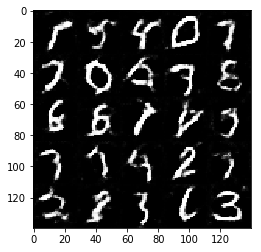

Epoch 1/2... Batch 510... Discriminator Loss: 1.3688... Generator Loss: 0.9834
Epoch 1/2... Batch 520... Discriminator Loss: 1.3668... Generator Loss: 0.6621
Epoch 1/2... Batch 530... Discriminator Loss: 1.4482... Generator Loss: 1.3320
Epoch 1/2... Batch 540... Discriminator Loss: 1.2518... Generator Loss: 0.9559
Epoch 1/2... Batch 550... Discriminator Loss: 1.3747... Generator Loss: 0.6154


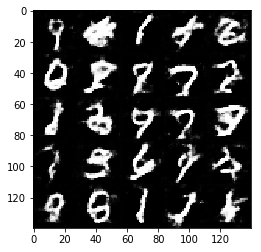

Epoch 1/2... Batch 560... Discriminator Loss: 1.2968... Generator Loss: 0.7448
Epoch 1/2... Batch 570... Discriminator Loss: 1.3461... Generator Loss: 1.2063
Epoch 1/2... Batch 580... Discriminator Loss: 1.3270... Generator Loss: 0.6688
Epoch 1/2... Batch 590... Discriminator Loss: 1.3805... Generator Loss: 0.6751
Epoch 1/2... Batch 600... Discriminator Loss: 1.2673... Generator Loss: 0.6759


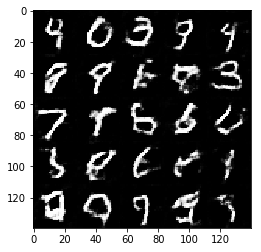

Epoch 1/2... Batch 610... Discriminator Loss: 1.3419... Generator Loss: 0.7025
Epoch 1/2... Batch 620... Discriminator Loss: 1.5096... Generator Loss: 0.4784
Epoch 1/2... Batch 630... Discriminator Loss: 1.3059... Generator Loss: 0.9097
Epoch 1/2... Batch 640... Discriminator Loss: 1.3365... Generator Loss: 1.1212
Epoch 1/2... Batch 650... Discriminator Loss: 1.3712... Generator Loss: 0.5999


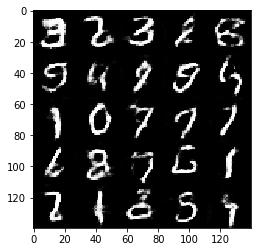

Epoch 1/2... Batch 660... Discriminator Loss: 1.3403... Generator Loss: 0.5894
Epoch 1/2... Batch 670... Discriminator Loss: 1.4179... Generator Loss: 1.5262
Epoch 1/2... Batch 680... Discriminator Loss: 1.2129... Generator Loss: 1.3132
Epoch 1/2... Batch 690... Discriminator Loss: 1.2981... Generator Loss: 0.7987
Epoch 1/2... Batch 700... Discriminator Loss: 1.2410... Generator Loss: 1.1492


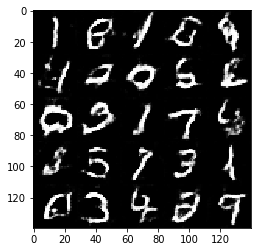

Epoch 1/2... Batch 710... Discriminator Loss: 1.3413... Generator Loss: 0.6460
Epoch 1/2... Batch 720... Discriminator Loss: 1.6386... Generator Loss: 0.3978
Epoch 1/2... Batch 730... Discriminator Loss: 1.4015... Generator Loss: 1.1287
Epoch 1/2... Batch 740... Discriminator Loss: 1.2881... Generator Loss: 0.9637
Epoch 1/2... Batch 750... Discriminator Loss: 1.3713... Generator Loss: 0.5974


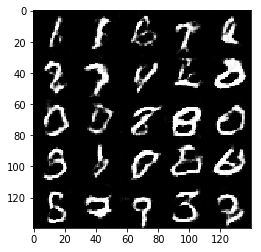

Epoch 1/2... Batch 760... Discriminator Loss: 1.2845... Generator Loss: 0.6538
Epoch 1/2... Batch 770... Discriminator Loss: 1.2836... Generator Loss: 0.8468
Epoch 1/2... Batch 780... Discriminator Loss: 1.5786... Generator Loss: 0.3804
Epoch 1/2... Batch 790... Discriminator Loss: 1.4169... Generator Loss: 1.2129
Epoch 1/2... Batch 800... Discriminator Loss: 1.4519... Generator Loss: 1.1785


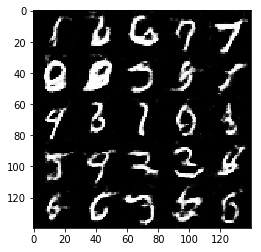

Epoch 1/2... Batch 810... Discriminator Loss: 1.2410... Generator Loss: 0.7631
Epoch 1/2... Batch 820... Discriminator Loss: 1.3248... Generator Loss: 0.5562
Epoch 1/2... Batch 830... Discriminator Loss: 1.5083... Generator Loss: 0.4378
Epoch 1/2... Batch 840... Discriminator Loss: 1.8726... Generator Loss: 1.6437
Epoch 1/2... Batch 850... Discriminator Loss: 1.4443... Generator Loss: 0.5807


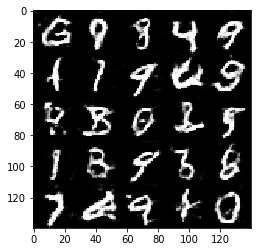

Epoch 1/2... Batch 860... Discriminator Loss: 1.4631... Generator Loss: 0.4683
Epoch 1/2... Batch 870... Discriminator Loss: 1.5551... Generator Loss: 0.4251
Epoch 1/2... Batch 880... Discriminator Loss: 1.4617... Generator Loss: 0.4776
Epoch 1/2... Batch 890... Discriminator Loss: 1.2342... Generator Loss: 0.8275
Epoch 1/2... Batch 900... Discriminator Loss: 1.4238... Generator Loss: 0.5442


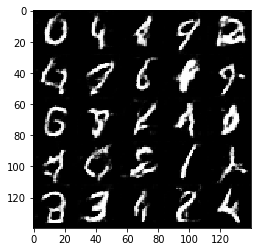

Epoch 1/2... Batch 910... Discriminator Loss: 1.2723... Generator Loss: 0.9547
Epoch 1/2... Batch 920... Discriminator Loss: 1.6180... Generator Loss: 0.4007
Epoch 1/2... Batch 930... Discriminator Loss: 1.1723... Generator Loss: 0.7914


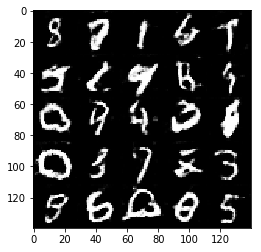

Epoch 2/2... Batch 0... Discriminator Loss: 1.2499... Generator Loss: 0.8168


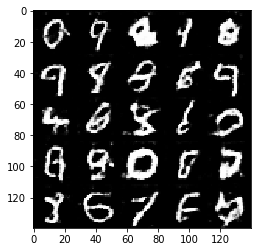

Epoch 2/2... Batch 10... Discriminator Loss: 1.6245... Generator Loss: 0.3662
Epoch 2/2... Batch 20... Discriminator Loss: 1.7398... Generator Loss: 0.3555
Epoch 2/2... Batch 30... Discriminator Loss: 1.3260... Generator Loss: 1.0135
Epoch 2/2... Batch 40... Discriminator Loss: 1.3599... Generator Loss: 1.5071
Epoch 2/2... Batch 50... Discriminator Loss: 1.2050... Generator Loss: 1.2297


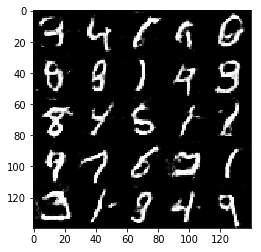

Epoch 2/2... Batch 60... Discriminator Loss: 1.3322... Generator Loss: 0.8319
Epoch 2/2... Batch 70... Discriminator Loss: 1.3834... Generator Loss: 0.5968
Epoch 2/2... Batch 80... Discriminator Loss: 1.7249... Generator Loss: 1.5775
Epoch 2/2... Batch 90... Discriminator Loss: 1.4399... Generator Loss: 0.7358
Epoch 2/2... Batch 100... Discriminator Loss: 1.4934... Generator Loss: 0.4615


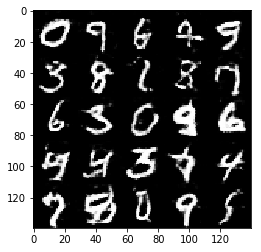

Epoch 2/2... Batch 110... Discriminator Loss: 1.3903... Generator Loss: 0.5272
Epoch 2/2... Batch 120... Discriminator Loss: 1.4370... Generator Loss: 0.5166
Epoch 2/2... Batch 130... Discriminator Loss: 1.0848... Generator Loss: 0.9328
Epoch 2/2... Batch 140... Discriminator Loss: 1.3050... Generator Loss: 0.6687
Epoch 2/2... Batch 150... Discriminator Loss: 1.4311... Generator Loss: 0.5924


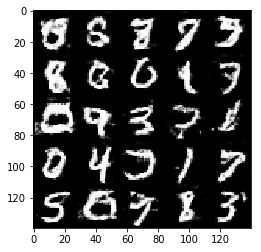

Epoch 2/2... Batch 160... Discriminator Loss: 1.3191... Generator Loss: 0.5906
Epoch 2/2... Batch 170... Discriminator Loss: 1.3362... Generator Loss: 0.5976
Epoch 2/2... Batch 180... Discriminator Loss: 1.7631... Generator Loss: 0.3772
Epoch 2/2... Batch 190... Discriminator Loss: 1.3233... Generator Loss: 0.8231
Epoch 2/2... Batch 200... Discriminator Loss: 1.3076... Generator Loss: 0.7415


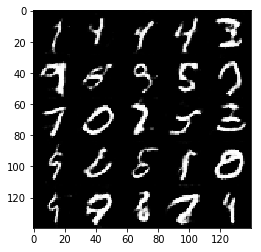

Epoch 2/2... Batch 210... Discriminator Loss: 1.3467... Generator Loss: 1.3567
Epoch 2/2... Batch 220... Discriminator Loss: 1.2935... Generator Loss: 0.6473
Epoch 2/2... Batch 230... Discriminator Loss: 1.3201... Generator Loss: 0.6368
Epoch 2/2... Batch 240... Discriminator Loss: 1.2302... Generator Loss: 0.7558
Epoch 2/2... Batch 250... Discriminator Loss: 1.5227... Generator Loss: 0.4294


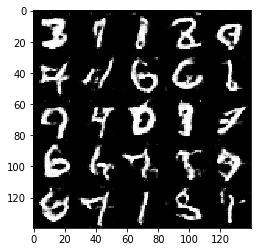

Epoch 2/2... Batch 260... Discriminator Loss: 1.2504... Generator Loss: 0.7411
Epoch 2/2... Batch 270... Discriminator Loss: 1.8839... Generator Loss: 0.2914
Epoch 2/2... Batch 280... Discriminator Loss: 1.3883... Generator Loss: 0.5025
Epoch 2/2... Batch 290... Discriminator Loss: 1.4099... Generator Loss: 0.5320
Epoch 2/2... Batch 300... Discriminator Loss: 1.1968... Generator Loss: 0.9211


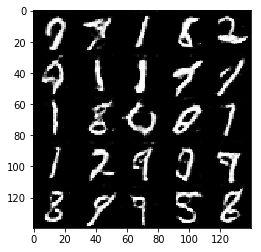

Epoch 2/2... Batch 310... Discriminator Loss: 1.3714... Generator Loss: 0.6764
Epoch 2/2... Batch 320... Discriminator Loss: 1.3923... Generator Loss: 0.5796
Epoch 2/2... Batch 330... Discriminator Loss: 1.2119... Generator Loss: 0.8117
Epoch 2/2... Batch 340... Discriminator Loss: 1.2751... Generator Loss: 0.6767
Epoch 2/2... Batch 350... Discriminator Loss: 1.5469... Generator Loss: 1.1845


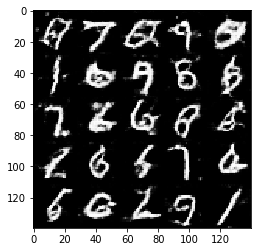

Epoch 2/2... Batch 360... Discriminator Loss: 1.2989... Generator Loss: 1.0267
Epoch 2/2... Batch 370... Discriminator Loss: 1.5940... Generator Loss: 0.4556
Epoch 2/2... Batch 380... Discriminator Loss: 1.3258... Generator Loss: 0.6233
Epoch 2/2... Batch 390... Discriminator Loss: 1.3621... Generator Loss: 0.6044
Epoch 2/2... Batch 400... Discriminator Loss: 1.2358... Generator Loss: 0.7805


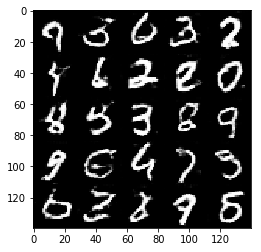

Epoch 2/2... Batch 410... Discriminator Loss: 1.2761... Generator Loss: 0.7774
Epoch 2/2... Batch 420... Discriminator Loss: 1.1853... Generator Loss: 1.0226
Epoch 2/2... Batch 430... Discriminator Loss: 1.3622... Generator Loss: 0.7822
Epoch 2/2... Batch 440... Discriminator Loss: 1.2249... Generator Loss: 0.7372
Epoch 2/2... Batch 450... Discriminator Loss: 1.5408... Generator Loss: 0.4817


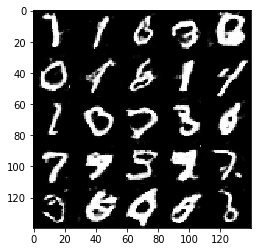

Epoch 2/2... Batch 460... Discriminator Loss: 1.3632... Generator Loss: 1.1094
Epoch 2/2... Batch 470... Discriminator Loss: 1.4051... Generator Loss: 0.7109
Epoch 2/2... Batch 480... Discriminator Loss: 1.3655... Generator Loss: 0.5774
Epoch 2/2... Batch 490... Discriminator Loss: 1.8809... Generator Loss: 0.2830
Epoch 2/2... Batch 500... Discriminator Loss: 1.4799... Generator Loss: 0.5553


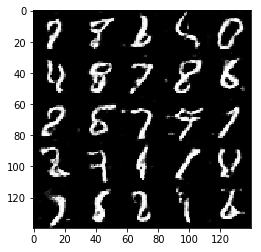

Epoch 2/2... Batch 510... Discriminator Loss: 1.2918... Generator Loss: 0.6835
Epoch 2/2... Batch 520... Discriminator Loss: 1.4026... Generator Loss: 0.7922
Epoch 2/2... Batch 530... Discriminator Loss: 1.4445... Generator Loss: 0.5194
Epoch 2/2... Batch 540... Discriminator Loss: 1.2734... Generator Loss: 0.6662
Epoch 2/2... Batch 550... Discriminator Loss: 1.5974... Generator Loss: 1.5129


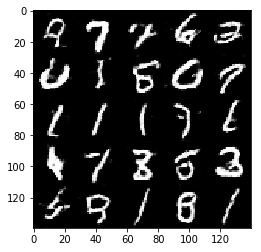

Epoch 2/2... Batch 560... Discriminator Loss: 1.2387... Generator Loss: 0.8886
Epoch 2/2... Batch 570... Discriminator Loss: 1.2640... Generator Loss: 0.7893
Epoch 2/2... Batch 580... Discriminator Loss: 1.3551... Generator Loss: 1.3713
Epoch 2/2... Batch 590... Discriminator Loss: 1.1629... Generator Loss: 1.2498
Epoch 2/2... Batch 600... Discriminator Loss: 1.4241... Generator Loss: 0.5262


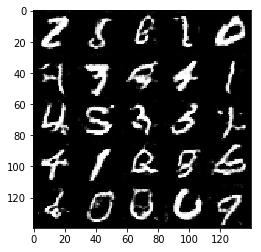

Epoch 2/2... Batch 610... Discriminator Loss: 1.5501... Generator Loss: 0.4244
Epoch 2/2... Batch 620... Discriminator Loss: 1.3321... Generator Loss: 0.6324
Epoch 2/2... Batch 630... Discriminator Loss: 1.3597... Generator Loss: 0.5777
Epoch 2/2... Batch 640... Discriminator Loss: 1.3246... Generator Loss: 0.7025
Epoch 2/2... Batch 650... Discriminator Loss: 1.3174... Generator Loss: 0.7069


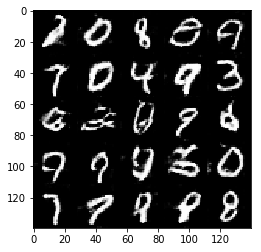

Epoch 2/2... Batch 660... Discriminator Loss: 1.4378... Generator Loss: 0.4781
Epoch 2/2... Batch 670... Discriminator Loss: 1.3522... Generator Loss: 0.8444
Epoch 2/2... Batch 680... Discriminator Loss: 1.2589... Generator Loss: 0.7412
Epoch 2/2... Batch 690... Discriminator Loss: 1.3675... Generator Loss: 1.1608
Epoch 2/2... Batch 700... Discriminator Loss: 1.2531... Generator Loss: 0.8467


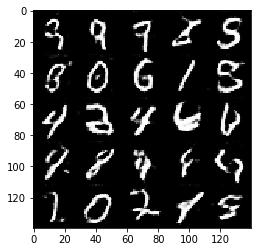

Epoch 2/2... Batch 710... Discriminator Loss: 1.3237... Generator Loss: 0.6641
Epoch 2/2... Batch 720... Discriminator Loss: 1.0522... Generator Loss: 1.0793
Epoch 2/2... Batch 730... Discriminator Loss: 1.3194... Generator Loss: 1.4067
Epoch 2/2... Batch 740... Discriminator Loss: 1.4453... Generator Loss: 0.5683
Epoch 2/2... Batch 750... Discriminator Loss: 1.3093... Generator Loss: 0.6491


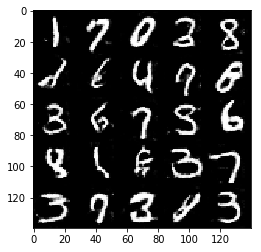

Epoch 2/2... Batch 760... Discriminator Loss: 1.1957... Generator Loss: 0.7678
Epoch 2/2... Batch 770... Discriminator Loss: 1.4904... Generator Loss: 0.4608
Epoch 2/2... Batch 780... Discriminator Loss: 1.2064... Generator Loss: 0.8240
Epoch 2/2... Batch 790... Discriminator Loss: 1.4474... Generator Loss: 0.5125
Epoch 2/2... Batch 800... Discriminator Loss: 1.2230... Generator Loss: 0.7249


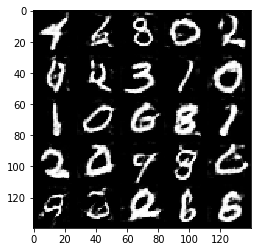

Epoch 2/2... Batch 810... Discriminator Loss: 1.2275... Generator Loss: 0.8165
Epoch 2/2... Batch 820... Discriminator Loss: 1.2171... Generator Loss: 0.8008
Epoch 2/2... Batch 830... Discriminator Loss: 1.5820... Generator Loss: 0.4527
Epoch 2/2... Batch 840... Discriminator Loss: 1.4252... Generator Loss: 0.5544
Epoch 2/2... Batch 850... Discriminator Loss: 1.3497... Generator Loss: 0.7406


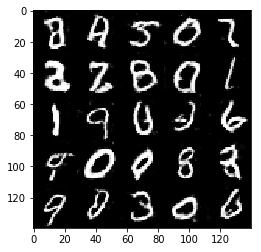

Epoch 2/2... Batch 860... Discriminator Loss: 1.6229... Generator Loss: 0.4145
Epoch 2/2... Batch 870... Discriminator Loss: 1.6805... Generator Loss: 0.3774
Epoch 2/2... Batch 880... Discriminator Loss: 1.2723... Generator Loss: 0.7315
Epoch 2/2... Batch 890... Discriminator Loss: 1.1544... Generator Loss: 1.0498
Epoch 2/2... Batch 900... Discriminator Loss: 1.2414... Generator Loss: 0.7753


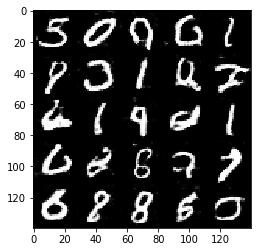

Epoch 2/2... Batch 910... Discriminator Loss: 1.7511... Generator Loss: 0.3326
Epoch 2/2... Batch 920... Discriminator Loss: 1.6650... Generator Loss: 0.3772
Epoch 2/2... Batch 930... Discriminator Loss: 1.3733... Generator Loss: 0.7419


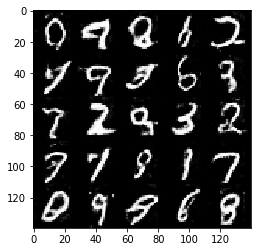

In [120]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take a|round 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Image width 28, image height 28 image channels 3
z_dim 100
Epoch 1/1... Batch 0... Discriminator Loss: 5.2205... Generator Loss: 0.0096


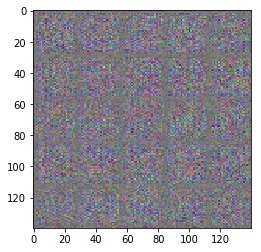

Epoch 1/1... Batch 10... Discriminator Loss: 2.2052... Generator Loss: 0.2685
Epoch 1/1... Batch 20... Discriminator Loss: 0.6574... Generator Loss: 1.8238
Epoch 1/1... Batch 30... Discriminator Loss: 0.8995... Generator Loss: 1.0827
Epoch 1/1... Batch 40... Discriminator Loss: 2.7426... Generator Loss: 0.1877
Epoch 1/1... Batch 50... Discriminator Loss: 1.5686... Generator Loss: 1.0806


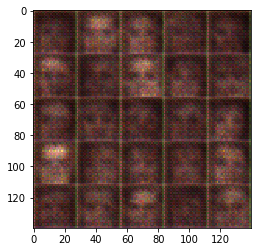

Epoch 1/1... Batch 60... Discriminator Loss: 1.8076... Generator Loss: 1.1004
Epoch 1/1... Batch 70... Discriminator Loss: 1.8123... Generator Loss: 0.5067
Epoch 1/1... Batch 80... Discriminator Loss: 1.7031... Generator Loss: 1.1467
Epoch 1/1... Batch 90... Discriminator Loss: 1.7192... Generator Loss: 0.7206
Epoch 1/1... Batch 100... Discriminator Loss: 1.6814... Generator Loss: 0.5708


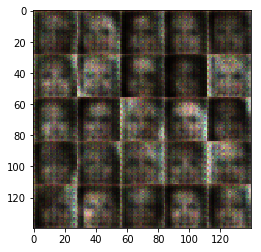

Epoch 1/1... Batch 110... Discriminator Loss: 1.6494... Generator Loss: 0.6168
Epoch 1/1... Batch 120... Discriminator Loss: 1.6657... Generator Loss: 0.5691
Epoch 1/1... Batch 130... Discriminator Loss: 1.8407... Generator Loss: 0.3796
Epoch 1/1... Batch 140... Discriminator Loss: 1.9563... Generator Loss: 0.5376
Epoch 1/1... Batch 150... Discriminator Loss: 1.7140... Generator Loss: 0.5082


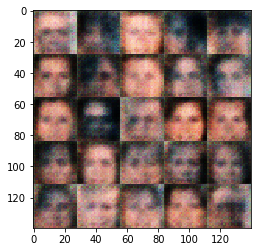

Epoch 1/1... Batch 160... Discriminator Loss: 1.5429... Generator Loss: 0.6989
Epoch 1/1... Batch 170... Discriminator Loss: 1.5763... Generator Loss: 0.8158
Epoch 1/1... Batch 180... Discriminator Loss: 1.3791... Generator Loss: 0.8762
Epoch 1/1... Batch 190... Discriminator Loss: 1.4200... Generator Loss: 0.6918
Epoch 1/1... Batch 200... Discriminator Loss: 1.3857... Generator Loss: 0.7965


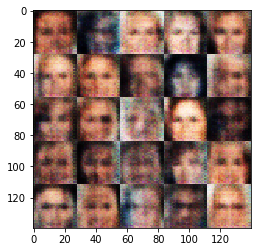

Epoch 1/1... Batch 210... Discriminator Loss: 1.4951... Generator Loss: 0.6029
Epoch 1/1... Batch 220... Discriminator Loss: 1.3606... Generator Loss: 0.8164
Epoch 1/1... Batch 230... Discriminator Loss: 1.3846... Generator Loss: 1.2420
Epoch 1/1... Batch 240... Discriminator Loss: 1.2943... Generator Loss: 0.7079
Epoch 1/1... Batch 250... Discriminator Loss: 1.6025... Generator Loss: 0.8701


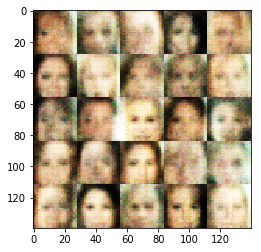

Epoch 1/1... Batch 260... Discriminator Loss: 1.2771... Generator Loss: 1.6766
Epoch 1/1... Batch 270... Discriminator Loss: 1.6416... Generator Loss: 0.4909
Epoch 1/1... Batch 280... Discriminator Loss: 1.8213... Generator Loss: 0.3229
Epoch 1/1... Batch 290... Discriminator Loss: 1.6430... Generator Loss: 1.2621
Epoch 1/1... Batch 300... Discriminator Loss: 1.5775... Generator Loss: 0.7199


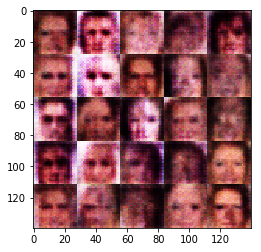

Epoch 1/1... Batch 310... Discriminator Loss: 1.6387... Generator Loss: 0.5042
Epoch 1/1... Batch 320... Discriminator Loss: 1.6324... Generator Loss: 0.6306
Epoch 1/1... Batch 330... Discriminator Loss: 1.4933... Generator Loss: 0.6657
Epoch 1/1... Batch 340... Discriminator Loss: 1.3858... Generator Loss: 0.7218
Epoch 1/1... Batch 350... Discriminator Loss: 1.6241... Generator Loss: 0.5077


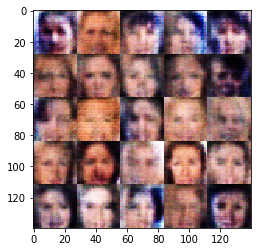

Epoch 1/1... Batch 360... Discriminator Loss: 1.5886... Generator Loss: 0.7541
Epoch 1/1... Batch 370... Discriminator Loss: 1.4467... Generator Loss: 0.6476
Epoch 1/1... Batch 380... Discriminator Loss: 1.4879... Generator Loss: 0.7561
Epoch 1/1... Batch 390... Discriminator Loss: 1.4986... Generator Loss: 0.8381
Epoch 1/1... Batch 400... Discriminator Loss: 1.5690... Generator Loss: 0.7848


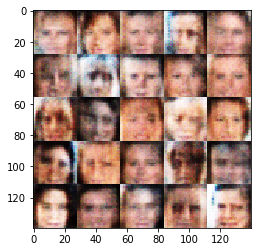

Epoch 1/1... Batch 410... Discriminator Loss: 1.5814... Generator Loss: 0.6884
Epoch 1/1... Batch 420... Discriminator Loss: 1.5268... Generator Loss: 0.7349
Epoch 1/1... Batch 430... Discriminator Loss: 1.4833... Generator Loss: 0.6992
Epoch 1/1... Batch 440... Discriminator Loss: 1.5648... Generator Loss: 0.7612
Epoch 1/1... Batch 450... Discriminator Loss: 1.3771... Generator Loss: 0.7255


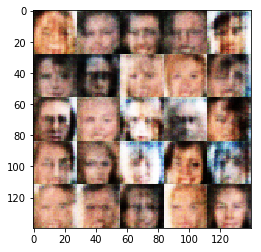

Epoch 1/1... Batch 460... Discriminator Loss: 1.4787... Generator Loss: 0.7700
Epoch 1/1... Batch 470... Discriminator Loss: 1.5851... Generator Loss: 0.6497
Epoch 1/1... Batch 480... Discriminator Loss: 1.5409... Generator Loss: 0.6049
Epoch 1/1... Batch 490... Discriminator Loss: 1.4454... Generator Loss: 0.6702
Epoch 1/1... Batch 500... Discriminator Loss: 1.4854... Generator Loss: 0.7940


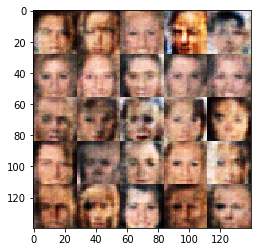

Epoch 1/1... Batch 510... Discriminator Loss: 1.3758... Generator Loss: 0.7082
Epoch 1/1... Batch 520... Discriminator Loss: 1.4482... Generator Loss: 0.7204
Epoch 1/1... Batch 530... Discriminator Loss: 1.4023... Generator Loss: 0.7848
Epoch 1/1... Batch 540... Discriminator Loss: 1.4402... Generator Loss: 0.7047
Epoch 1/1... Batch 550... Discriminator Loss: 1.3734... Generator Loss: 0.8409


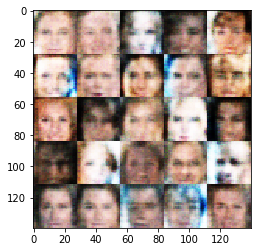

Epoch 1/1... Batch 560... Discriminator Loss: 1.6448... Generator Loss: 0.7607
Epoch 1/1... Batch 570... Discriminator Loss: 1.5308... Generator Loss: 0.7357
Epoch 1/1... Batch 580... Discriminator Loss: 1.4274... Generator Loss: 0.8399
Epoch 1/1... Batch 590... Discriminator Loss: 1.5636... Generator Loss: 0.5940
Epoch 1/1... Batch 600... Discriminator Loss: 1.3705... Generator Loss: 0.9478


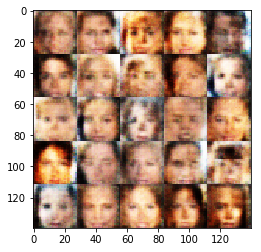

Epoch 1/1... Batch 610... Discriminator Loss: 1.4970... Generator Loss: 0.9076
Epoch 1/1... Batch 620... Discriminator Loss: 1.5013... Generator Loss: 0.6629
Epoch 1/1... Batch 630... Discriminator Loss: 1.5055... Generator Loss: 0.7254
Epoch 1/1... Batch 640... Discriminator Loss: 1.5237... Generator Loss: 0.6189
Epoch 1/1... Batch 650... Discriminator Loss: 1.4319... Generator Loss: 0.6921


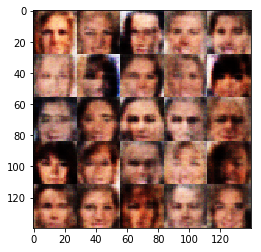

Epoch 1/1... Batch 660... Discriminator Loss: 1.5492... Generator Loss: 0.6250
Epoch 1/1... Batch 670... Discriminator Loss: 1.4032... Generator Loss: 0.8424
Epoch 1/1... Batch 680... Discriminator Loss: 1.5535... Generator Loss: 0.8345
Epoch 1/1... Batch 690... Discriminator Loss: 1.4944... Generator Loss: 0.7136
Epoch 1/1... Batch 700... Discriminator Loss: 1.3572... Generator Loss: 0.7367


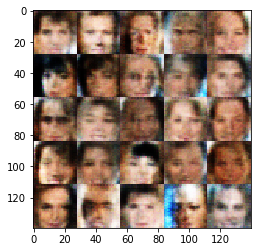

Epoch 1/1... Batch 710... Discriminator Loss: 1.4299... Generator Loss: 0.7031
Epoch 1/1... Batch 720... Discriminator Loss: 1.4274... Generator Loss: 0.8282
Epoch 1/1... Batch 730... Discriminator Loss: 1.4732... Generator Loss: 0.6574
Epoch 1/1... Batch 740... Discriminator Loss: 1.4949... Generator Loss: 0.7929
Epoch 1/1... Batch 750... Discriminator Loss: 1.4255... Generator Loss: 0.7293


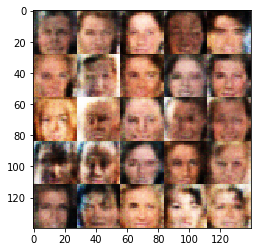

Epoch 1/1... Batch 760... Discriminator Loss: 1.4259... Generator Loss: 0.7641
Epoch 1/1... Batch 770... Discriminator Loss: 1.4825... Generator Loss: 0.7812
Epoch 1/1... Batch 780... Discriminator Loss: 1.4251... Generator Loss: 0.7692
Epoch 1/1... Batch 790... Discriminator Loss: 1.4690... Generator Loss: 0.7988
Epoch 1/1... Batch 800... Discriminator Loss: 1.5152... Generator Loss: 0.7129


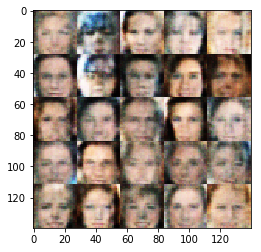

Epoch 1/1... Batch 810... Discriminator Loss: 1.4925... Generator Loss: 0.6976
Epoch 1/1... Batch 820... Discriminator Loss: 1.5117... Generator Loss: 0.7225
Epoch 1/1... Batch 830... Discriminator Loss: 1.4028... Generator Loss: 0.7395
Epoch 1/1... Batch 840... Discriminator Loss: 1.5267... Generator Loss: 0.6306
Epoch 1/1... Batch 850... Discriminator Loss: 1.5328... Generator Loss: 0.7992


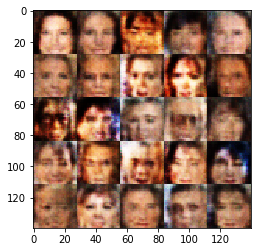

Epoch 1/1... Batch 860... Discriminator Loss: 1.4512... Generator Loss: 0.6856
Epoch 1/1... Batch 870... Discriminator Loss: 1.4548... Generator Loss: 0.6690
Epoch 1/1... Batch 880... Discriminator Loss: 1.5063... Generator Loss: 0.6167
Epoch 1/1... Batch 890... Discriminator Loss: 1.4797... Generator Loss: 0.6874
Epoch 1/1... Batch 900... Discriminator Loss: 1.4157... Generator Loss: 0.7696


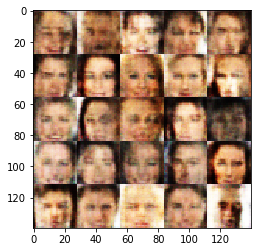

Epoch 1/1... Batch 910... Discriminator Loss: 1.5053... Generator Loss: 0.6247
Epoch 1/1... Batch 920... Discriminator Loss: 1.4527... Generator Loss: 0.7294
Epoch 1/1... Batch 930... Discriminator Loss: 1.4587... Generator Loss: 0.7834
Epoch 1/1... Batch 940... Discriminator Loss: 1.4025... Generator Loss: 0.7843
Epoch 1/1... Batch 950... Discriminator Loss: 1.4724... Generator Loss: 0.7458


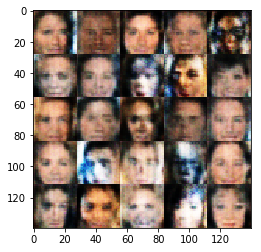

Epoch 1/1... Batch 960... Discriminator Loss: 1.4181... Generator Loss: 0.8139
Epoch 1/1... Batch 970... Discriminator Loss: 1.4437... Generator Loss: 0.7243
Epoch 1/1... Batch 980... Discriminator Loss: 1.4442... Generator Loss: 0.8149
Epoch 1/1... Batch 990... Discriminator Loss: 1.4417... Generator Loss: 0.8063
Epoch 1/1... Batch 1000... Discriminator Loss: 1.4658... Generator Loss: 0.6819


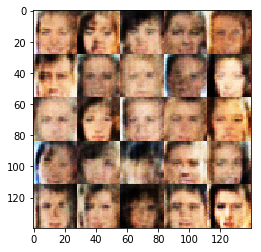

Epoch 1/1... Batch 1010... Discriminator Loss: 1.5450... Generator Loss: 0.8279
Epoch 1/1... Batch 1020... Discriminator Loss: 1.3032... Generator Loss: 0.8165
Epoch 1/1... Batch 1030... Discriminator Loss: 1.5290... Generator Loss: 0.6674
Epoch 1/1... Batch 1040... Discriminator Loss: 1.4499... Generator Loss: 0.8161
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4167... Generator Loss: 0.7314


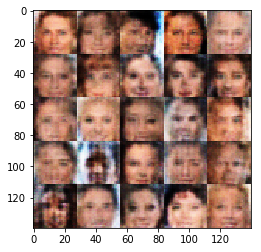

Epoch 1/1... Batch 1060... Discriminator Loss: 1.3846... Generator Loss: 0.7947
Epoch 1/1... Batch 1070... Discriminator Loss: 1.5001... Generator Loss: 0.8589
Epoch 1/1... Batch 1080... Discriminator Loss: 1.4215... Generator Loss: 0.7619
Epoch 1/1... Batch 1090... Discriminator Loss: 1.4763... Generator Loss: 0.6586
Epoch 1/1... Batch 1100... Discriminator Loss: 1.4478... Generator Loss: 0.9460


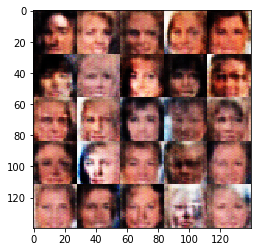

Epoch 1/1... Batch 1110... Discriminator Loss: 1.6002... Generator Loss: 0.7512
Epoch 1/1... Batch 1120... Discriminator Loss: 1.4376... Generator Loss: 0.5700
Epoch 1/1... Batch 1130... Discriminator Loss: 1.5777... Generator Loss: 0.6418
Epoch 1/1... Batch 1140... Discriminator Loss: 1.3819... Generator Loss: 0.7794
Epoch 1/1... Batch 1150... Discriminator Loss: 1.4211... Generator Loss: 0.7968


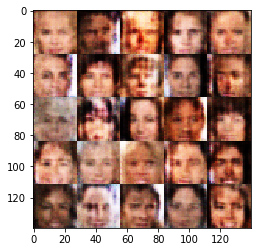

Epoch 1/1... Batch 1160... Discriminator Loss: 1.4121... Generator Loss: 0.7291
Epoch 1/1... Batch 1170... Discriminator Loss: 1.4027... Generator Loss: 0.6917
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4380... Generator Loss: 0.7709
Epoch 1/1... Batch 1190... Discriminator Loss: 1.3959... Generator Loss: 1.0479
Epoch 1/1... Batch 1200... Discriminator Loss: 1.4629... Generator Loss: 1.0268


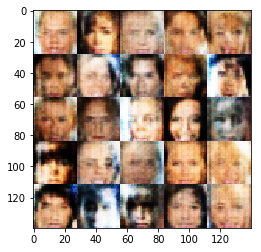

Epoch 1/1... Batch 1210... Discriminator Loss: 1.3999... Generator Loss: 0.7632
Epoch 1/1... Batch 1220... Discriminator Loss: 1.3792... Generator Loss: 0.9277
Epoch 1/1... Batch 1230... Discriminator Loss: 1.3041... Generator Loss: 1.0031
Epoch 1/1... Batch 1240... Discriminator Loss: 1.7707... Generator Loss: 0.3272
Epoch 1/1... Batch 1250... Discriminator Loss: 1.4810... Generator Loss: 0.7041


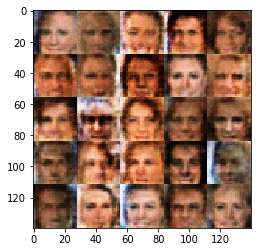

Epoch 1/1... Batch 1260... Discriminator Loss: 1.4521... Generator Loss: 0.7575
Epoch 1/1... Batch 1270... Discriminator Loss: 1.4003... Generator Loss: 0.8071
Epoch 1/1... Batch 1280... Discriminator Loss: 1.4076... Generator Loss: 0.7702
Epoch 1/1... Batch 1290... Discriminator Loss: 1.4129... Generator Loss: 0.7391
Epoch 1/1... Batch 1300... Discriminator Loss: 1.4821... Generator Loss: 0.6509


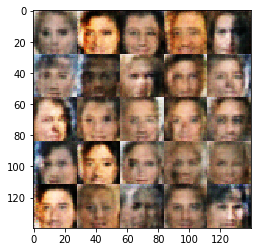

Epoch 1/1... Batch 1310... Discriminator Loss: 1.4187... Generator Loss: 0.7642
Epoch 1/1... Batch 1320... Discriminator Loss: 1.4511... Generator Loss: 0.7064
Epoch 1/1... Batch 1330... Discriminator Loss: 1.3292... Generator Loss: 0.9061
Epoch 1/1... Batch 1340... Discriminator Loss: 1.4659... Generator Loss: 0.7604
Epoch 1/1... Batch 1350... Discriminator Loss: 1.4546... Generator Loss: 0.8136


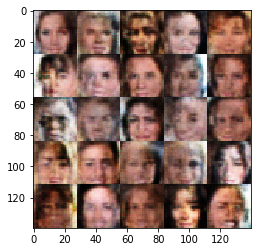

Epoch 1/1... Batch 1360... Discriminator Loss: 1.4929... Generator Loss: 0.7357
Epoch 1/1... Batch 1370... Discriminator Loss: 1.4932... Generator Loss: 0.7548
Epoch 1/1... Batch 1380... Discriminator Loss: 1.4167... Generator Loss: 0.8380
Epoch 1/1... Batch 1390... Discriminator Loss: 1.4849... Generator Loss: 0.7051
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3767... Generator Loss: 0.7600


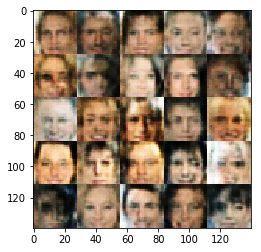

Epoch 1/1... Batch 1410... Discriminator Loss: 1.4527... Generator Loss: 0.7260
Epoch 1/1... Batch 1420... Discriminator Loss: 1.4997... Generator Loss: 0.6892
Epoch 1/1... Batch 1430... Discriminator Loss: 1.3841... Generator Loss: 0.7147
Epoch 1/1... Batch 1440... Discriminator Loss: 1.5439... Generator Loss: 0.6785
Epoch 1/1... Batch 1450... Discriminator Loss: 1.4628... Generator Loss: 0.6801


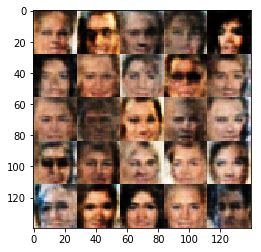

Epoch 1/1... Batch 1460... Discriminator Loss: 1.4187... Generator Loss: 0.7617
Epoch 1/1... Batch 1470... Discriminator Loss: 1.4357... Generator Loss: 0.6527
Epoch 1/1... Batch 1480... Discriminator Loss: 1.3652... Generator Loss: 0.8094
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3781... Generator Loss: 0.7320
Epoch 1/1... Batch 1500... Discriminator Loss: 1.4483... Generator Loss: 0.7597


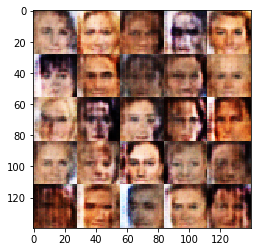

Epoch 1/1... Batch 1510... Discriminator Loss: 1.4007... Generator Loss: 0.7223
Epoch 1/1... Batch 1520... Discriminator Loss: 1.4859... Generator Loss: 0.6904
Epoch 1/1... Batch 1530... Discriminator Loss: 1.5390... Generator Loss: 0.7063
Epoch 1/1... Batch 1540... Discriminator Loss: 1.4204... Generator Loss: 0.7527
Epoch 1/1... Batch 1550... Discriminator Loss: 1.4680... Generator Loss: 0.7732


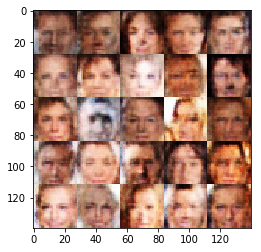

Epoch 1/1... Batch 1560... Discriminator Loss: 1.4279... Generator Loss: 0.7463
Epoch 1/1... Batch 1570... Discriminator Loss: 1.4442... Generator Loss: 0.7627
Epoch 1/1... Batch 1580... Discriminator Loss: 1.4316... Generator Loss: 0.7094
Epoch 1/1... Batch 1590... Discriminator Loss: 1.4234... Generator Loss: 0.7049
Epoch 1/1... Batch 1600... Discriminator Loss: 1.4991... Generator Loss: 0.8250


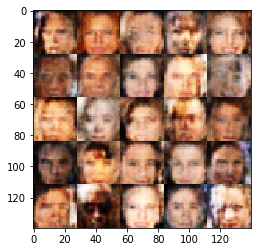

Epoch 1/1... Batch 1610... Discriminator Loss: 1.4700... Generator Loss: 0.7924
Epoch 1/1... Batch 1620... Discriminator Loss: 1.5105... Generator Loss: 0.6809
Epoch 1/1... Batch 1630... Discriminator Loss: 1.4348... Generator Loss: 0.7611
Epoch 1/1... Batch 1640... Discriminator Loss: 1.3892... Generator Loss: 0.8256
Epoch 1/1... Batch 1650... Discriminator Loss: 1.4628... Generator Loss: 0.7788


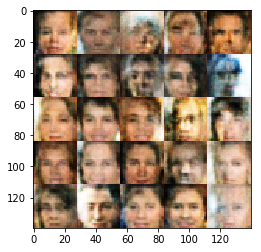

Epoch 1/1... Batch 1660... Discriminator Loss: 1.3462... Generator Loss: 0.9014
Epoch 1/1... Batch 1670... Discriminator Loss: 1.4050... Generator Loss: 0.7893
Epoch 1/1... Batch 1680... Discriminator Loss: 1.4257... Generator Loss: 0.8091
Epoch 1/1... Batch 1690... Discriminator Loss: 1.4828... Generator Loss: 0.6589
Epoch 1/1... Batch 1700... Discriminator Loss: 1.4036... Generator Loss: 0.7930


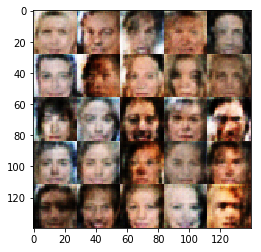

Epoch 1/1... Batch 1710... Discriminator Loss: 1.4274... Generator Loss: 0.7140
Epoch 1/1... Batch 1720... Discriminator Loss: 1.4282... Generator Loss: 0.7308
Epoch 1/1... Batch 1730... Discriminator Loss: 1.4647... Generator Loss: 0.7808
Epoch 1/1... Batch 1740... Discriminator Loss: 1.4627... Generator Loss: 0.8263
Epoch 1/1... Batch 1750... Discriminator Loss: 1.4433... Generator Loss: 0.7351


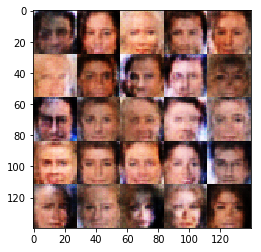

Epoch 1/1... Batch 1760... Discriminator Loss: 1.4184... Generator Loss: 0.8051
Epoch 1/1... Batch 1770... Discriminator Loss: 1.4379... Generator Loss: 0.8457
Epoch 1/1... Batch 1780... Discriminator Loss: 1.4045... Generator Loss: 0.8100
Epoch 1/1... Batch 1790... Discriminator Loss: 1.4442... Generator Loss: 0.9394
Epoch 1/1... Batch 1800... Discriminator Loss: 1.4882... Generator Loss: 0.6354


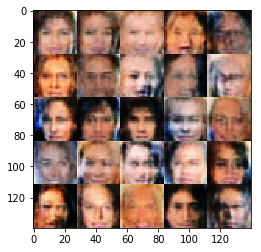

Epoch 1/1... Batch 1810... Discriminator Loss: 1.4076... Generator Loss: 0.7940
Epoch 1/1... Batch 1820... Discriminator Loss: 1.5016... Generator Loss: 0.6966
Epoch 1/1... Batch 1830... Discriminator Loss: 1.4857... Generator Loss: 0.7302
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4050... Generator Loss: 0.7746
Epoch 1/1... Batch 1850... Discriminator Loss: 1.4455... Generator Loss: 0.7136


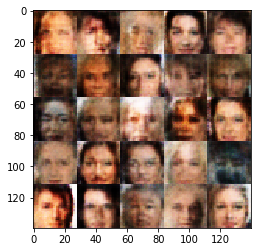

Epoch 1/1... Batch 1860... Discriminator Loss: 1.4226... Generator Loss: 0.7476
Epoch 1/1... Batch 1870... Discriminator Loss: 1.3835... Generator Loss: 0.8630
Epoch 1/1... Batch 1880... Discriminator Loss: 1.4236... Generator Loss: 0.7426
Epoch 1/1... Batch 1890... Discriminator Loss: 1.4856... Generator Loss: 0.6585
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3880... Generator Loss: 0.9145


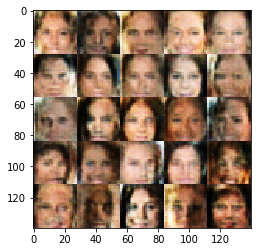

Epoch 1/1... Batch 1910... Discriminator Loss: 1.4577... Generator Loss: 0.7720
Epoch 1/1... Batch 1920... Discriminator Loss: 1.4231... Generator Loss: 0.6954
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3833... Generator Loss: 0.8121
Epoch 1/1... Batch 1940... Discriminator Loss: 1.4055... Generator Loss: 0.7478
Epoch 1/1... Batch 1950... Discriminator Loss: 1.4211... Generator Loss: 0.8063


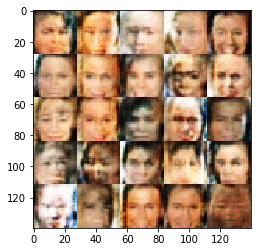

Epoch 1/1... Batch 1960... Discriminator Loss: 1.5417... Generator Loss: 0.8144
Epoch 1/1... Batch 1970... Discriminator Loss: 1.4269... Generator Loss: 0.6498
Epoch 1/1... Batch 1980... Discriminator Loss: 1.4746... Generator Loss: 0.6794
Epoch 1/1... Batch 1990... Discriminator Loss: 1.4293... Generator Loss: 0.7957
Epoch 1/1... Batch 2000... Discriminator Loss: 1.4470... Generator Loss: 0.7312


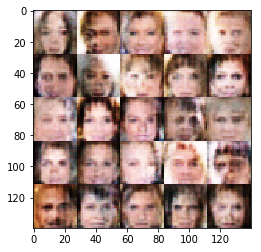

Epoch 1/1... Batch 2010... Discriminator Loss: 1.4391... Generator Loss: 0.7136
Epoch 1/1... Batch 2020... Discriminator Loss: 1.3777... Generator Loss: 0.6914
Epoch 1/1... Batch 2030... Discriminator Loss: 1.4336... Generator Loss: 0.6967
Epoch 1/1... Batch 2040... Discriminator Loss: 1.4954... Generator Loss: 0.7280
Epoch 1/1... Batch 2050... Discriminator Loss: 1.4824... Generator Loss: 0.7220


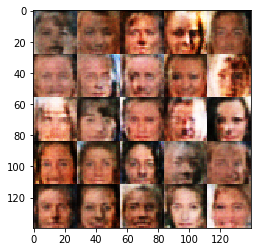

Epoch 1/1... Batch 2060... Discriminator Loss: 1.5067... Generator Loss: 0.6906
Epoch 1/1... Batch 2070... Discriminator Loss: 1.4173... Generator Loss: 0.8550
Epoch 1/1... Batch 2080... Discriminator Loss: 1.4170... Generator Loss: 0.6641
Epoch 1/1... Batch 2090... Discriminator Loss: 1.4694... Generator Loss: 0.6401
Epoch 1/1... Batch 2100... Discriminator Loss: 1.4380... Generator Loss: 1.0579


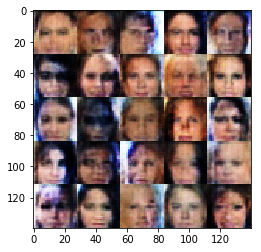

Epoch 1/1... Batch 2110... Discriminator Loss: 1.3905... Generator Loss: 0.8535
Epoch 1/1... Batch 2120... Discriminator Loss: 1.3757... Generator Loss: 0.8126
Epoch 1/1... Batch 2130... Discriminator Loss: 1.4878... Generator Loss: 0.4990
Epoch 1/1... Batch 2140... Discriminator Loss: 1.4303... Generator Loss: 0.6258
Epoch 1/1... Batch 2150... Discriminator Loss: 1.3187... Generator Loss: 1.0492


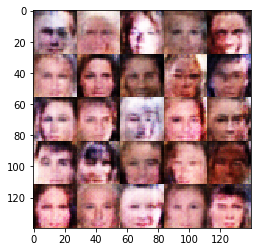

Epoch 1/1... Batch 2160... Discriminator Loss: 1.3970... Generator Loss: 0.7718
Epoch 1/1... Batch 2170... Discriminator Loss: 1.4760... Generator Loss: 0.5685
Epoch 1/1... Batch 2180... Discriminator Loss: 1.6046... Generator Loss: 0.4647
Epoch 1/1... Batch 2190... Discriminator Loss: 1.5385... Generator Loss: 0.6483
Epoch 1/1... Batch 2200... Discriminator Loss: 1.5139... Generator Loss: 0.6704


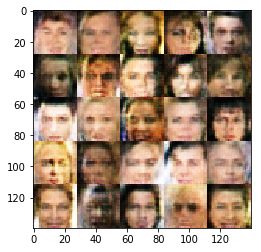

Epoch 1/1... Batch 2210... Discriminator Loss: 1.4230... Generator Loss: 0.6964
Epoch 1/1... Batch 2220... Discriminator Loss: 1.4306... Generator Loss: 0.8082
Epoch 1/1... Batch 2230... Discriminator Loss: 1.3606... Generator Loss: 0.8358
Epoch 1/1... Batch 2240... Discriminator Loss: 1.4370... Generator Loss: 0.7164
Epoch 1/1... Batch 2250... Discriminator Loss: 1.5027... Generator Loss: 0.5559


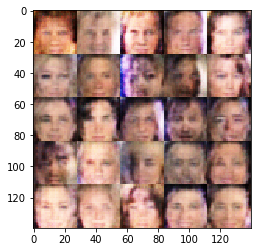

Epoch 1/1... Batch 2260... Discriminator Loss: 1.5305... Generator Loss: 0.8143
Epoch 1/1... Batch 2270... Discriminator Loss: 1.4719... Generator Loss: 0.6737
Epoch 1/1... Batch 2280... Discriminator Loss: 1.3497... Generator Loss: 0.7635
Epoch 1/1... Batch 2290... Discriminator Loss: 1.5030... Generator Loss: 0.9295
Epoch 1/1... Batch 2300... Discriminator Loss: 1.4590... Generator Loss: 0.6894


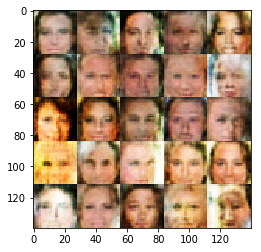

Epoch 1/1... Batch 2310... Discriminator Loss: 1.4195... Generator Loss: 0.8471
Epoch 1/1... Batch 2320... Discriminator Loss: 1.4364... Generator Loss: 0.6447
Epoch 1/1... Batch 2330... Discriminator Loss: 1.3878... Generator Loss: 1.0482
Epoch 1/1... Batch 2340... Discriminator Loss: 1.5295... Generator Loss: 0.7788
Epoch 1/1... Batch 2350... Discriminator Loss: 1.4339... Generator Loss: 0.8364


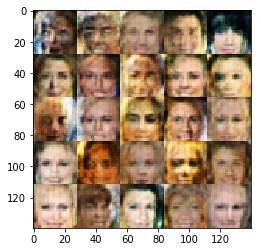

Epoch 1/1... Batch 2360... Discriminator Loss: 1.4324... Generator Loss: 0.9083
Epoch 1/1... Batch 2370... Discriminator Loss: 1.4282... Generator Loss: 0.7904
Epoch 1/1... Batch 2380... Discriminator Loss: 1.4200... Generator Loss: 0.7062
Epoch 1/1... Batch 2390... Discriminator Loss: 1.4401... Generator Loss: 0.8012
Epoch 1/1... Batch 2400... Discriminator Loss: 1.4200... Generator Loss: 0.7404


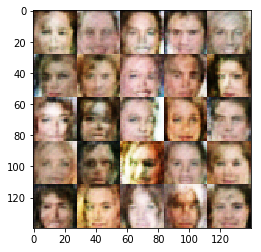

Epoch 1/1... Batch 2410... Discriminator Loss: 1.4297... Generator Loss: 0.7577
Epoch 1/1... Batch 2420... Discriminator Loss: 1.3880... Generator Loss: 0.7699
Epoch 1/1... Batch 2430... Discriminator Loss: 1.4372... Generator Loss: 0.7590
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3859... Generator Loss: 0.8234
Epoch 1/1... Batch 2450... Discriminator Loss: 1.3792... Generator Loss: 0.7148


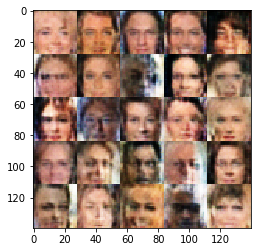

Epoch 1/1... Batch 2460... Discriminator Loss: 1.5298... Generator Loss: 0.7304
Epoch 1/1... Batch 2470... Discriminator Loss: 1.5674... Generator Loss: 0.6019
Epoch 1/1... Batch 2480... Discriminator Loss: 1.3631... Generator Loss: 0.8090
Epoch 1/1... Batch 2490... Discriminator Loss: 1.3836... Generator Loss: 0.6697
Epoch 1/1... Batch 2500... Discriminator Loss: 1.4928... Generator Loss: 0.7071


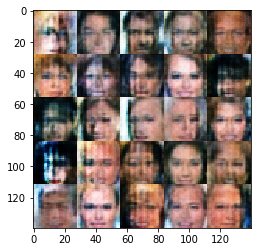

Epoch 1/1... Batch 2510... Discriminator Loss: 1.4761... Generator Loss: 0.7319
Epoch 1/1... Batch 2520... Discriminator Loss: 1.4386... Generator Loss: 0.6872
Epoch 1/1... Batch 2530... Discriminator Loss: 1.4193... Generator Loss: 0.7699
Epoch 1/1... Batch 2540... Discriminator Loss: 1.4296... Generator Loss: 0.7357
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3446... Generator Loss: 0.8653


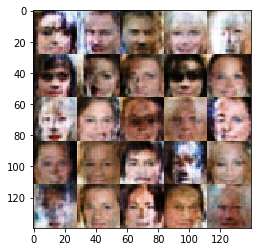

Epoch 1/1... Batch 2560... Discriminator Loss: 1.4278... Generator Loss: 0.7318
Epoch 1/1... Batch 2570... Discriminator Loss: 1.3887... Generator Loss: 0.8706
Epoch 1/1... Batch 2580... Discriminator Loss: 1.4314... Generator Loss: 0.7357
Epoch 1/1... Batch 2590... Discriminator Loss: 1.4557... Generator Loss: 0.6418
Epoch 1/1... Batch 2600... Discriminator Loss: 1.5054... Generator Loss: 0.6541


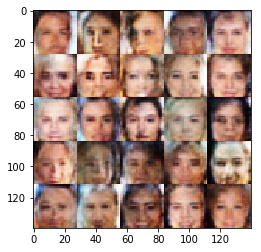

Epoch 1/1... Batch 2610... Discriminator Loss: 1.4110... Generator Loss: 0.7511
Epoch 1/1... Batch 2620... Discriminator Loss: 1.3895... Generator Loss: 0.7533
Epoch 1/1... Batch 2630... Discriminator Loss: 1.4889... Generator Loss: 0.6772
Epoch 1/1... Batch 2640... Discriminator Loss: 1.3785... Generator Loss: 0.8139
Epoch 1/1... Batch 2650... Discriminator Loss: 1.4093... Generator Loss: 0.8577


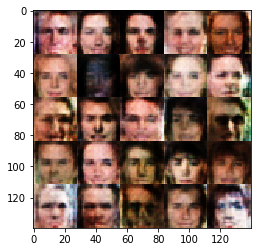

Epoch 1/1... Batch 2660... Discriminator Loss: 1.3908... Generator Loss: 0.7655
Epoch 1/1... Batch 2670... Discriminator Loss: 1.4392... Generator Loss: 0.6736
Epoch 1/1... Batch 2680... Discriminator Loss: 1.5290... Generator Loss: 0.9419
Epoch 1/1... Batch 2690... Discriminator Loss: 1.5342... Generator Loss: 0.6441
Epoch 1/1... Batch 2700... Discriminator Loss: 1.5268... Generator Loss: 0.6159


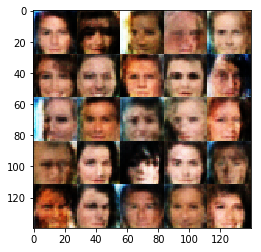

Epoch 1/1... Batch 2710... Discriminator Loss: 1.3110... Generator Loss: 0.8291
Epoch 1/1... Batch 2720... Discriminator Loss: 1.3848... Generator Loss: 0.8571
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3732... Generator Loss: 0.9271
Epoch 1/1... Batch 2740... Discriminator Loss: 1.3522... Generator Loss: 0.8762
Epoch 1/1... Batch 2750... Discriminator Loss: 1.3913... Generator Loss: 0.7266


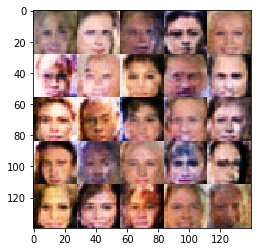

Epoch 1/1... Batch 2760... Discriminator Loss: 1.3857... Generator Loss: 0.8394
Epoch 1/1... Batch 2770... Discriminator Loss: 1.3805... Generator Loss: 0.9098
Epoch 1/1... Batch 2780... Discriminator Loss: 1.4240... Generator Loss: 0.6974
Epoch 1/1... Batch 2790... Discriminator Loss: 1.4320... Generator Loss: 0.7328
Epoch 1/1... Batch 2800... Discriminator Loss: 1.3559... Generator Loss: 0.8087


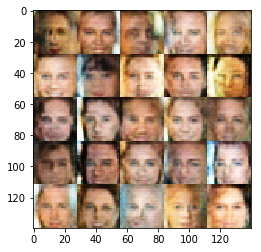

Epoch 1/1... Batch 2810... Discriminator Loss: 1.4439... Generator Loss: 0.8652
Epoch 1/1... Batch 2820... Discriminator Loss: 1.4851... Generator Loss: 0.7051
Epoch 1/1... Batch 2830... Discriminator Loss: 1.4789... Generator Loss: 0.6866
Epoch 1/1... Batch 2840... Discriminator Loss: 1.3134... Generator Loss: 0.8554
Epoch 1/1... Batch 2850... Discriminator Loss: 1.4996... Generator Loss: 0.8284


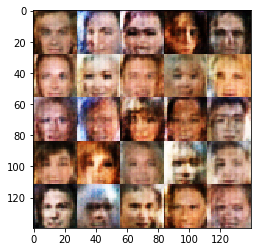

Epoch 1/1... Batch 2860... Discriminator Loss: 1.3839... Generator Loss: 0.8536
Epoch 1/1... Batch 2870... Discriminator Loss: 1.3821... Generator Loss: 0.8715
Epoch 1/1... Batch 2880... Discriminator Loss: 1.3733... Generator Loss: 0.7052
Epoch 1/1... Batch 2890... Discriminator Loss: 1.4629... Generator Loss: 0.6398
Epoch 1/1... Batch 2900... Discriminator Loss: 1.4411... Generator Loss: 0.8252


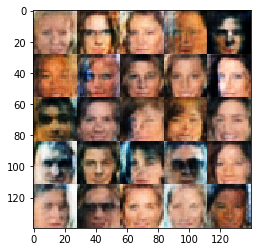

Epoch 1/1... Batch 2910... Discriminator Loss: 1.3081... Generator Loss: 0.7803
Epoch 1/1... Batch 2920... Discriminator Loss: 1.4533... Generator Loss: 0.8011
Epoch 1/1... Batch 2930... Discriminator Loss: 1.3920... Generator Loss: 0.7727
Epoch 1/1... Batch 2940... Discriminator Loss: 1.5386... Generator Loss: 0.7966
Epoch 1/1... Batch 2950... Discriminator Loss: 1.4149... Generator Loss: 0.6768


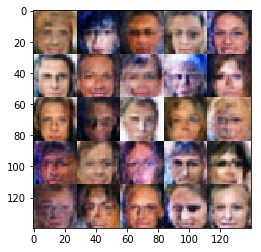

Epoch 1/1... Batch 2960... Discriminator Loss: 1.4719... Generator Loss: 0.6953
Epoch 1/1... Batch 2970... Discriminator Loss: 1.4312... Generator Loss: 0.6691
Epoch 1/1... Batch 2980... Discriminator Loss: 1.3828... Generator Loss: 0.7261
Epoch 1/1... Batch 2990... Discriminator Loss: 1.4343... Generator Loss: 0.8127
Epoch 1/1... Batch 3000... Discriminator Loss: 1.3881... Generator Loss: 0.7220


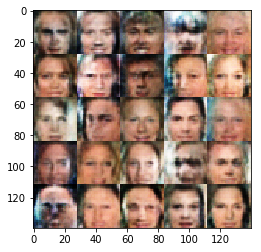

Epoch 1/1... Batch 3010... Discriminator Loss: 1.4503... Generator Loss: 0.7926
Epoch 1/1... Batch 3020... Discriminator Loss: 1.4221... Generator Loss: 0.6809
Epoch 1/1... Batch 3030... Discriminator Loss: 1.4972... Generator Loss: 0.6283
Epoch 1/1... Batch 3040... Discriminator Loss: 1.4725... Generator Loss: 0.8224
Epoch 1/1... Batch 3050... Discriminator Loss: 1.4166... Generator Loss: 0.7884


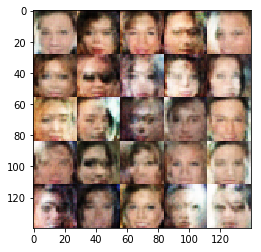

Epoch 1/1... Batch 3060... Discriminator Loss: 1.3782... Generator Loss: 0.6772
Epoch 1/1... Batch 3070... Discriminator Loss: 1.4324... Generator Loss: 0.7474
Epoch 1/1... Batch 3080... Discriminator Loss: 1.4256... Generator Loss: 0.7592
Epoch 1/1... Batch 3090... Discriminator Loss: 1.4314... Generator Loss: 0.6925
Epoch 1/1... Batch 3100... Discriminator Loss: 1.4412... Generator Loss: 0.7019


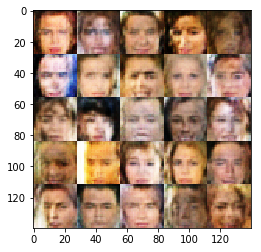

Epoch 1/1... Batch 3110... Discriminator Loss: 1.4104... Generator Loss: 0.8665
Epoch 1/1... Batch 3120... Discriminator Loss: 1.4452... Generator Loss: 0.8020
Epoch 1/1... Batch 3130... Discriminator Loss: 1.4223... Generator Loss: 0.8057
Epoch 1/1... Batch 3140... Discriminator Loss: 1.3970... Generator Loss: 0.8613
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3853... Generator Loss: 0.7473


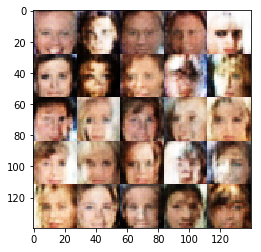

Epoch 1/1... Batch 3160... Discriminator Loss: 1.4005... Generator Loss: 0.7615


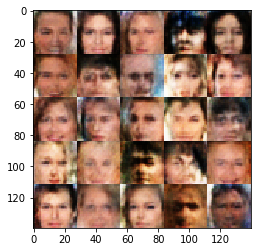

In [121]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.